In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score

import category_encoders as ce

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_train = pd.read_csv('../data/Train_data.csv')
raw_test = pd.read_csv('../data/Test_data.csv')

In [3]:
print(raw_train.info())
raw_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102 entries, 0 to 3101
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3102 non-null   float64
 1   job_type             3091 non-null   object 
 2   marital_status       3102 non-null   object 
 3   education_level      2989 non-null   object 
 4   default_or_not       3102 non-null   int64  
 5   balance_amt          3102 non-null   float64
 6   household_insurance  3102 non-null   int64  
 7   car_loan             3102 non-null   int64  
 8   communication        2559 non-null   object 
 9   last_contact_day     3102 non-null   int64  
 10  last_contact_month   3102 non-null   object 
 11  no_of_contacts       3102 non-null   int64  
 12  days_passed          3102 non-null   int64  
 13  prev_attempts        3102 non-null   int64  
 14  Outcome              751 non-null    object 
 15  call_start           3102 non-null   o

,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end,car_insurance
0,47.000000,blue-collar,married,primary,0,1112.000000,1,0,cellular,13,may,1,-1,0,NaN,10:22:20,10:24:29,0
1,46.031442,management,married,tertiary,0,1.312372,0,1,cellular,15,may,3,219,1,other,09:06:30,13:59:48,1
2,36.000000,services,single,NaN,0,281.000000,1,0,NaN,16,may,1,-1,0,NaN,13:18:41,13:27:16,1
3,32.000000,technician,single,secondary,0,540.000000,0,1,cellular,29,jan,1,-1,0,NaN,10:09:18,10:21:48,1
4,30.000000,admin.,single,secondary,0,315.000000,1,0,cellular,14,may,3,346,4,failure,12:12:30,12:27:14,1


In [4]:
print(raw_test.info())
raw_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935 entries, 0 to 934
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  935 non-null    float64
 1   job_type             930 non-null    object 
 2   marital_status       935 non-null    object 
 3   education_level      901 non-null    object 
 4   default_or_not       935 non-null    int64  
 5   balance_amt          935 non-null    float64
 6   household_insurance  935 non-null    int64  
 7   car_loan             935 non-null    int64  
 8   communication        770 non-null    object 
 9   last_contact_day     935 non-null    int64  
 10  last_contact_month   935 non-null    object 
 11  no_of_contacts       935 non-null    int64  
 12  days_passed          935 non-null    int64  
 13  prev_attempts        935 non-null    int64  
 14  Outcome              240 non-null    object 
 15  call_start           935 non-null    obj

,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end
0,65.000000,retired,married,secondary,0,20806.0,0,0,telephone,8,apr,2,-1,0,NaN,12:22:13,12:30:56
1,36.000000,management,married,tertiary,0,900.0,1,0,NaN,15,may,2,-1,0,NaN,17:59:45,18:07:40
2,37.000000,management,married,tertiary,0,6771.0,0,0,cellular,7,sep,1,186,1,success,14:05:19,14:10:56
3,30.065066,management,single,tertiary,0,0.0,0,0,cellular,14,may,2,-1,0,NaN,17:33:27,09:47:54
4,41.000000,management,married,tertiary,0,328.0,1,0,cellular,29,jul,12,-1,0,NaN,14:40:26,14:41:31


<AxesSubplot:>

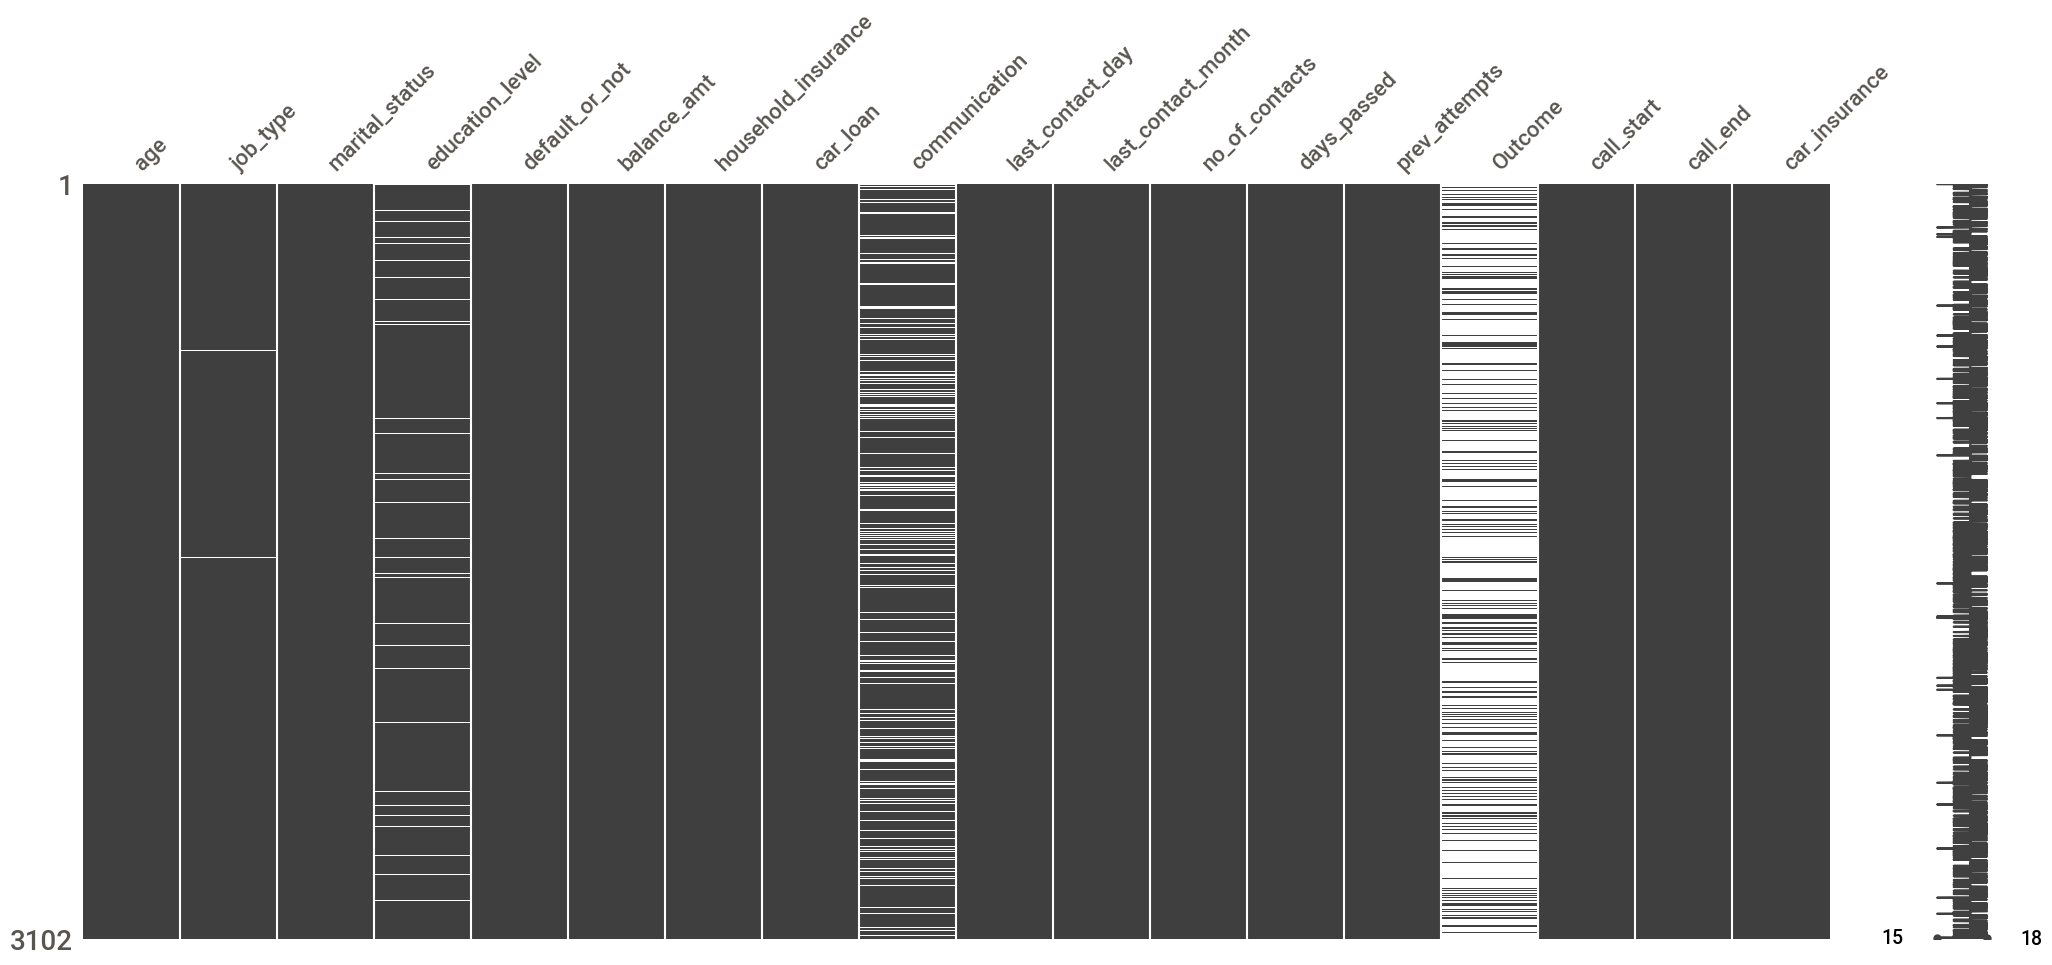

In [9]:
msno.matrix(raw_train)

<AxesSubplot:>

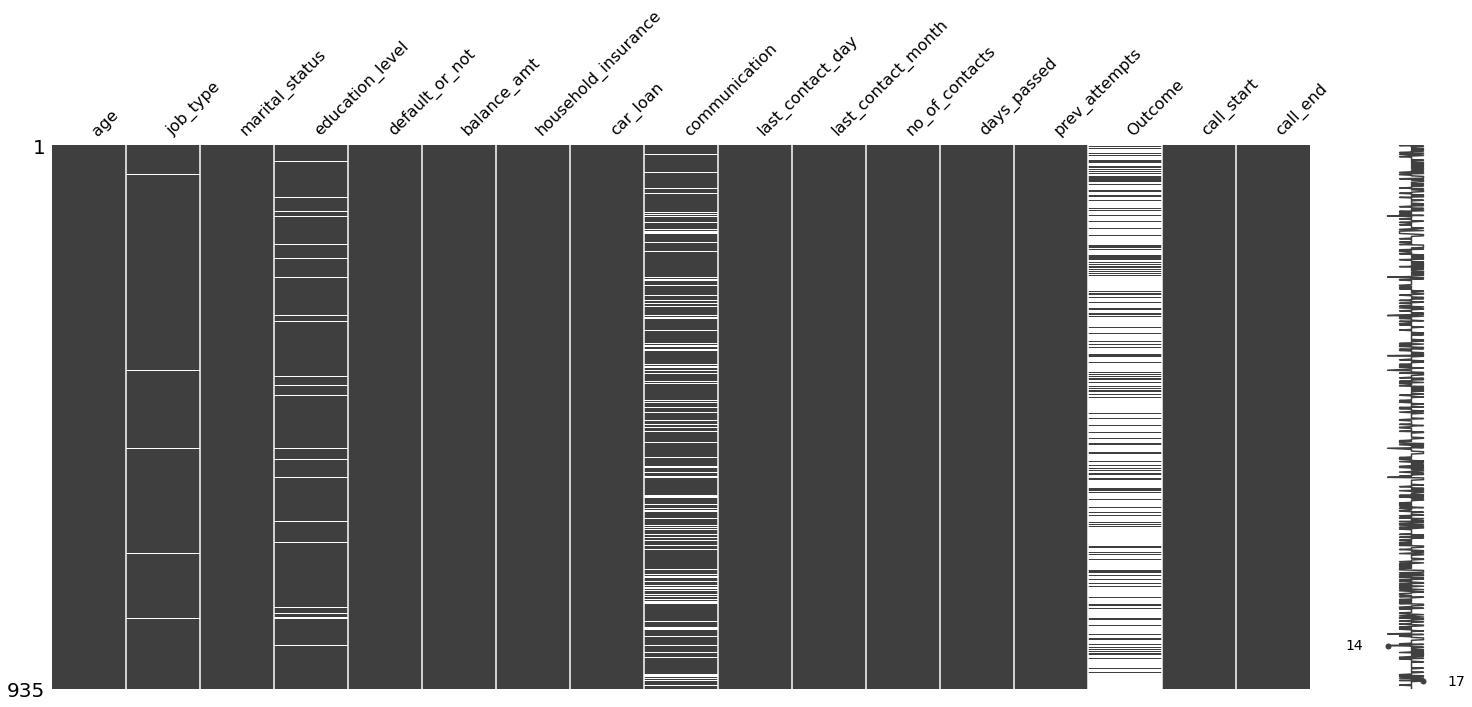

In [6]:
msno.matrix(raw_test)

In [4]:
df = raw_train.append(raw_test).reset_index(drop=True)
df = df.drop_duplicates()
df.shape

(3737, 18)

In [5]:
# drop default_or_not because of low variance
df.drop('default_or_not', axis=1, inplace=True)

In [6]:
df['Outcome'].fillna('unknown', inplace=True)
df['communication'].fillna(method='bfill', inplace=True)
df['education_level'].fillna(method='bfill', inplace=True)
df['job_type'].fillna(method='bfill', inplace=True)

assert df.drop('car_insurance', axis=1).isna().sum().any() == False, 'All null values not removed'

In [7]:
df['call_duration'] = (pd.to_datetime(df['call_end']) - pd.to_datetime(df['call_start'])).dt.seconds / 60
df.drop(['call_start', 'call_end'], axis=1, inplace=True)

In [8]:
df['age'] = df['age'].round(0).astype(int)

In [9]:
df['zero_neg_balance'] = df['balance_amt'].apply(lambda x: 1 if x <= 0 else 0)

In [10]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3737 entries, 0 to 4036
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3737 non-null   int64  
 1   job_type             3737 non-null   object 
 2   marital_status       3737 non-null   object 
 3   education_level      3737 non-null   object 
 4   balance_amt          3737 non-null   float64
 5   household_insurance  3737 non-null   int64  
 6   car_loan             3737 non-null   int64  
 7   communication        3737 non-null   object 
 8   last_contact_day     3737 non-null   int64  
 9   last_contact_month   3737 non-null   object 
 10  no_of_contacts       3737 non-null   int64  
 11  days_passed          3737 non-null   int64  
 12  prev_attempts        3737 non-null   int64  
 13  Outcome              3737 non-null   object 
 14  car_insurance        2802 non-null   float64
 15  call_duration        3737 non-null   f

,age,job_type,marital_status,education_level,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,car_insurance,call_duration,zero_neg_balance
0,47,blue-collar,married,primary,1112.000000,1,0,cellular,13,may,1,-1,0,unknown,0.0,2.150000,0
1,46,management,married,tertiary,1.312372,0,1,cellular,15,may,3,219,1,other,1.0,293.300000,0
2,36,services,single,secondary,281.000000,1,0,cellular,16,may,1,-1,0,unknown,1.0,8.583333,0
3,32,technician,single,secondary,540.000000,0,1,cellular,29,jan,1,-1,0,unknown,1.0,12.500000,0
4,30,admin.,single,secondary,315.000000,1,0,cellular,14,may,3,346,4,failure,1.0,14.733333,0


# approach 3

In [11]:
df = df.drop('days_passed', axis=1)

In [13]:
cat_cols = df.select_dtypes(include='object').columns.tolist() + ['last_contact_day']
cat_cols

['job_type',
 'marital_status',
 'education_level',
 'communication',
 'last_contact_month',
 'Outcome',
 'last_contact_day']

In [14]:
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [15]:
df.head()

,age,job_type,marital_status,education_level,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,prev_attempts,Outcome,car_insurance,call_duration,zero_neg_balance
0,47,1,1,0,1112.000000,1,0,0,12,8,1,0,3,0.0,2.150000,0
1,46,4,1,2,1.312372,0,1,0,14,8,3,1,1,1.0,293.300000,0
2,36,7,2,1,281.000000,1,0,0,15,8,1,0,3,1.0,8.583333,0
3,32,9,2,1,540.000000,0,1,0,28,4,1,0,3,1.0,12.500000,0
4,30,0,2,1,315.000000,1,0,0,13,8,3,4,0,1.0,14.733333,0


In [16]:
target_col = 'car_insurance'
mask = df[target_col].isna() == True

train = df.loc[~mask]
train[target_col] = train[target_col].astype(int)

test = df.loc[mask].drop(target_col, axis=1)

In [17]:
train.to_csv('../data/clean_train4.csv', index=False)
test.to_csv('../data/clean_test4.csv', index=False)

# approach 1

In [128]:
df['balance_amt'] = stats.mstats.winsorize(df['balance_amt'], limits=(0.1, 0.05))

In [124]:
df['days_passed'] = df['days_passed'].replace(-1, np.nan)

In [125]:
days_passed_null_dict = df.groupby(['last_contact_month', 'last_contact_day'])['days_passed'].mean().round().T.to_dict()
days_passed_null_dict2 = df.groupby('last_contact_month')['days_passed'].mean().round().T.to_dict()

mask = df['days_passed'].isna() == True
days_passed_null_idx = df.loc[mask].index

for i in days_passed_null_idx:
    key = (df['last_contact_month'][i], df['last_contact_day'][i])
    if np.isnan(days_passed_null_dict[key]):
        df['days_passed'][i] = days_passed_null_dict2[df['last_contact_month'][i]]
    else:
        df['days_passed'][i] = days_passed_null_dict[key]
        
print(df['days_passed'].isna().sum())
df['days_passed'] = df['days_passed'].astype(int)

0


In [94]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [131]:
df.head()

,age,job_type,marital_status,education_level,balance_amt,household_insurance,car_loan,communication,no_of_contacts,days_passed,prev_attempts,Outcome,car_insurance,call_duration,zero_neg_balance
0,47,blue-collar,married,primary,1112.000000,1,0,cellular,1,256,0,unknown,0.0,2.150000,0
1,46,management,married,tertiary,1.312372,0,1,cellular,3,219,1,other,1.0,293.300000,0
2,36,services,single,secondary,281.000000,1,0,cellular,1,96,0,unknown,1.0,8.583333,0
3,32,technician,single,secondary,540.000000,0,1,cellular,1,205,0,unknown,1.0,12.500000,0
4,30,admin.,single,secondary,315.000000,1,0,cellular,3,346,4,failure,1.0,14.733333,0


<AxesSubplot:>

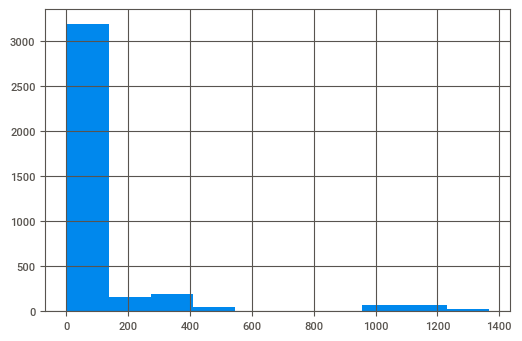

In [114]:
df['call_duration'].hist()

In [132]:
marital_status = pd.get_dummies(df['marital_status'], drop_first=True)
ed_lvl = pd.get_dummies(df['education_level'], drop_first=True)
outcome = pd.get_dummies(df['Outcome'], drop_first=True)

In [135]:
df.drop(['job_type', 'marital_status', 'education_level', 'communication', 'Outcome'], axis=1, inplace=True)

In [136]:
# df = pd.concat([df, marital_status, ed_lvl, outcome], axis=1)
df.head()

,age,balance_amt,household_insurance,car_loan,no_of_contacts,days_passed,prev_attempts,car_insurance,call_duration,zero_neg_balance,married,single,secondary,tertiary,other,success,unknown
0,47,1112.000000,1,0,1,256,0,0.0,2.150000,0,1,0,0,0,0,0,1
1,46,1.312372,0,1,3,219,1,1.0,293.300000,0,1,0,0,1,1,0,0
2,36,281.000000,1,0,1,96,0,1.0,8.583333,0,0,1,1,0,0,0,1
3,32,540.000000,0,1,1,205,0,1.0,12.500000,0,0,1,1,0,0,0,1
4,30,315.000000,1,0,3,346,4,1.0,14.733333,0,0,1,1,0,0,0,0


In [139]:
df.skew()

age                    0.798672
balance_amt            1.725318
household_insurance    0.154613
car_loan               2.355780
no_of_contacts         6.041978
days_passed            1.164042
prev_attempts          8.646566
car_insurance         -0.279833
call_duration          3.629379
zero_neg_balance       2.199978
married               -0.379497
single                 0.901572
secondary             -0.078471
tertiary               0.618005
other                  4.512124
success                2.619680
unknown               -1.177914
dtype: float64

In [140]:
mask = df['car_insurance'].isna() == True

train = df.loc[~mask]
train['car_insurance'] = train['car_insurance'].astype(int)

test = df.loc[mask].drop('car_insurance', axis=1)

In [141]:
train.to_csv('../data/clean_train3.csv', index=False)
test.to_csv('../data/clean_test3.csv', index=False)

In [98]:
cat_cols

['job_type', 'marital_status', 'education_level', 'communication', 'Outcome']

# approach 2

In [111]:
col = 'balance_amt'
prev_skew = df[col].skew()
print(prev_skew)

pt = PowerTransformer()

stats.skew(pt.fit_transform(df[[col]]).ravel())

1.7168054839974853


-0.20796861538554282

In [87]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)

    mapping = { k: v for k, v in zip(df_new[cluster_field_name], df_new.index)}
    df_final = df.copy()
    df_final[cluster_field_name] = df[cluster_field_name].map(mapping)
    return df_final

In [83]:
df['age'] = df['age'].round(0).astype(int)

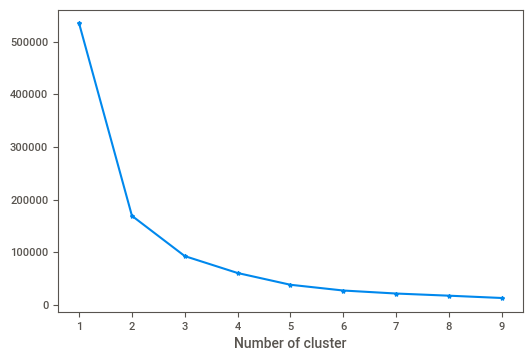

In [84]:
sse = {}
df_cluster = df[['age']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='*')
plt.xlabel("Number of cluster")
plt.show()

In [85]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['age']])
df['age_cluster'] = kmeans.predict(df[['age']])

In [86]:
df.groupby('age_cluster').mean()['age']

age_cluster
0    72.178571
1    40.965468
2    53.994898
3    30.332024
Name: age, dtype: float64

In [88]:
df = order_cluster('age_cluster', 'age', df, True)

In [90]:
df = df.drop('age', axis=1)
df.head()

,job_type,marital_status,education_level,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end,car_insurance,age_cluster
0,blue-collar,married,primary,1112.000000,1,0,cellular,13,may,1,-1,0,unknown,10:22:20,10:24:29,0.0,1
1,management,married,tertiary,1.312372,0,1,cellular,15,may,3,219,1,other,09:06:30,13:59:48,1.0,1
2,services,single,secondary,281.000000,1,0,cellular,16,may,1,-1,0,unknown,13:18:41,13:27:16,1.0,1
3,technician,single,secondary,540.000000,0,1,cellular,29,jan,1,-1,0,unknown,10:09:18,10:21:48,1.0,0
4,admin.,single,secondary,315.000000,1,0,cellular,14,may,3,346,4,failure,12:12:30,12:27:14,1.0,0


In [91]:
job_type = pd.get_dummies(df['job_type'], drop_first=True)
marital_status = pd.get_dummies(df['marital_status'], drop_first=True)
ed_lvl = pd.get_dummies(df['education_level'], drop_first=True)

In [92]:
df.drop(['job_type', 'marital_status', 'education_level'], axis=1, inplace=True)

In [93]:
df = pd.concat([df, job_type, marital_status, ed_lvl], axis=1)
df.head()

,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,...,retired,self-employed,services,student,technician,unemployed,married,single,secondary,tertiary
0,1112.000000,1,0,cellular,13,may,1,-1,0,unknown,...,0,0,0,0,0,0,1,0,0,0
1,1.312372,0,1,cellular,15,may,3,219,1,other,...,0,0,0,0,0,0,1,0,0,1
2,281.000000,1,0,cellular,16,may,1,-1,0,unknown,...,0,0,1,0,0,0,0,1,1,0
3,540.000000,0,1,cellular,29,jan,1,-1,0,unknown,...,0,0,0,0,1,0,0,1,1,0
4,315.000000,1,0,cellular,14,may,3,346,4,failure,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4032,152.000000,1,1,cellular,8,jul,1,-1,0,unknown,...,0,0,0,0,0,0,1,0,1,0
4033,53.000000,1,0,cellular,18,jul,5,-1,0,unknown,...,0,0,0,0,1,0,0,1,1,0
4034,36.000000,0,0,cellular,21,nov,3,-1,0,unknown,...,0,0,0,0,0,0,1,0,0,1
4035,2948.000000,0,0,cellular,21,nov,1,-1,0,unknown,...,0,0,1,0,0,0,1,0,1,0


In [96]:
mask = raw_train['balance_amt'] < 0
raw_train.loc[mask]

,age,job_type,marital_status,education_level,default_or_not,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,call_start,call_end,car_insurance
36,57.968820,retired,married,secondary,0,-578.611059,0,0,cellular,23,jun,5,-1,0,NaN,09:41:48,17:16:28,1
39,27.000000,services,single,secondary,0,-195.000000,1,0,cellular,18,may,1,-1,0,NaN,10:51:19,10:57:50,1
40,39.000000,services,single,secondary,0,-244.000000,1,0,NaN,8,may,2,-1,0,NaN,09:12:25,09:14:57,0
45,34.508390,technician,married,secondary,0,-12.155994,0,0,cellular,16,jun,2,-1,0,NaN,11:06:59,14:03:36,1
52,36.104556,admin.,married,secondary,1,-487.261391,1,0,cellular,16,may,1,-1,0,NaN,09:06:10,16:57:45,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033,26.000000,management,single,tertiary,0,-8.000000,0,0,cellular,13,aug,2,-1,0,NaN,13:40:27,13:47:09,0
3045,39.581908,blue-collar,married,secondary,0,-230.421651,1,0,NaN,16,jul,1,-1,0,NaN,10:03:29,17:11:47,1
3070,38.000000,management,married,tertiary,1,-1007.000000,1,1,NaN,19,jun,1,-1,0,NaN,10:44:38,10:45:49,0
3071,47.000000,technician,married,secondary,0,-107.000000,0,0,cellular,8,jul,2,-1,0,NaN,12:24:54,12:28:50,0


In [110]:
df['balance_amt'] = stats.mstats.winsorize(df['balance_amt'], limits=(0.1, 0.05))

In [112]:
pt = PowerTransformer()
df['balance_amt'] = pt.fit_transform(df[['balance_amt']]).ravel()

In [113]:
df.head()

,balance_amt,household_insurance,car_loan,communication,last_contact_day,last_contact_month,no_of_contacts,days_passed,prev_attempts,Outcome,...,retired,self-employed,services,student,technician,unemployed,married,single,secondary,tertiary
0,0.442486,1,0,cellular,13,may,1,-1,0,unknown,...,0,0,0,0,0,0,1,0,0,0
1,-1.589477,0,1,cellular,15,may,3,219,1,other,...,0,0,0,0,0,0,1,0,0,1
2,-0.273878,1,0,cellular,16,may,1,-1,0,unknown,...,0,0,1,0,0,0,0,1,1,0
3,0.038881,0,1,cellular,29,jan,1,-1,0,unknown,...,0,0,0,0,1,0,0,1,1,0
4,-0.222452,1,0,cellular,14,may,3,346,4,failure,...,0,0,0,0,0,0,0,1,1,0


In [109]:
pd.DataFrame(stats.mstats.winsorize(df['balance_amt'], limits=[0.1, 0.05])).describe()

,0
count,4037.000000
mean,1299.098827
std,1715.939610
min,0.000000
25%,121.000000
50%,594.000000
75%,1737.000000
max,6289.454221


In [114]:
comm = pd.get_dummies(df['communication'], drop_first=True)

In [115]:
df = pd.concat([df, comm], axis=1)
df = df.drop('communication', axis=1)

In [116]:
le = LabelEncoder()
df['last_contact_month'] = le.fit_transform(df['last_contact_month'])

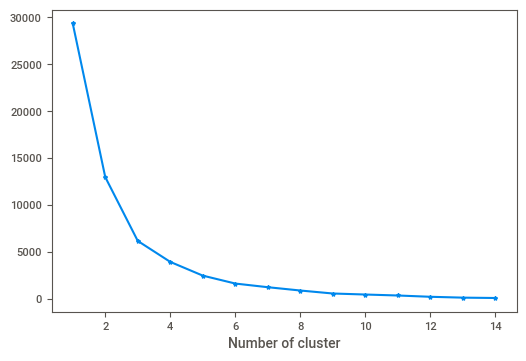

In [119]:
sse = {}
df_cluster = df[['no_of_contacts']]
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='*')
plt.xlabel("Number of cluster")
plt.show()

In [120]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[['no_of_contacts']])
df['contacts_cluster'] = kmeans.predict(df[['no_of_contacts']])

In [121]:
df = order_cluster('contacts_cluster', 'no_of_contacts', df, True)

In [124]:
df.drop('no_of_contacts', axis=1, inplace=True)

In [126]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   balance_amt          4037 non-null   float64
 1   household_insurance  4037 non-null   int64  
 2   car_loan             4037 non-null   int64  
 3   last_contact_day     4037 non-null   int64  
 4   last_contact_month   4037 non-null   int64  
 5   days_passed          4037 non-null   int64  
 6   prev_attempts        4037 non-null   int64  
 7   Outcome              4037 non-null   object 
 8   call_start           4037 non-null   object 
 9   call_end             4037 non-null   object 
 10  car_insurance        3102 non-null   float64
 11  age_cluster          4037 non-null   int64  
 12  blue-collar          4037 non-null   uint8  
 13  entrepreneur         4037 non-null   uint8  
 14  housemaid            4037 non-null   uint8  
 15  management           4037 non-null   u

,balance_amt,household_insurance,car_loan,last_contact_day,last_contact_month,days_passed,prev_attempts,Outcome,call_start,call_end,...,services,student,technician,unemployed,married,single,secondary,tertiary,telephone,contacts_cluster
0,0.442486,1,0,13,8,-1,0,unknown,10:22:20,10:24:29,...,0,0,0,0,1,0,0,0,0,0
1,-1.589477,0,1,15,8,219,1,other,09:06:30,13:59:48,...,0,0,0,0,1,0,0,1,0,1
2,-0.273878,1,0,16,8,-1,0,unknown,13:18:41,13:27:16,...,1,0,0,0,0,1,1,0,0,0
3,0.038881,0,1,29,4,-1,0,unknown,10:09:18,10:21:48,...,0,0,1,0,0,1,1,0,0,0
4,-0.222452,1,0,14,8,346,4,failure,12:12:30,12:27:14,...,0,0,0,0,0,1,1,0,0,1


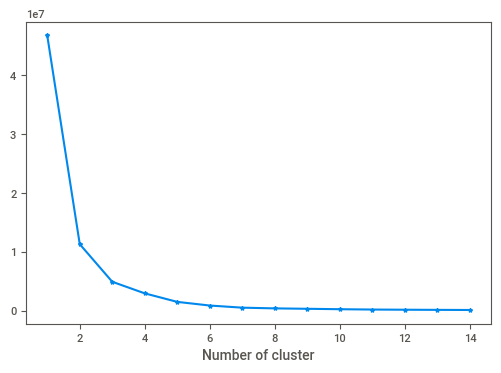

In [127]:
sse = {}
df_cluster = df[['days_passed']]
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='*')
plt.xlabel("Number of cluster")
plt.show()

In [128]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df[['days_passed']])
df['days_passed_cluster'] = kmeans.predict(df[['days_passed']])

In [129]:
df = order_cluster('days_passed_cluster', 'days_passed', df, True)

In [130]:
df.drop('days_passed', axis=1, inplace=True)

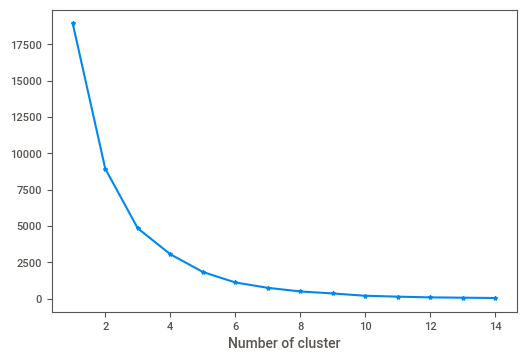

In [132]:
sse = {}
df_cluster = df[['prev_attempts']]
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='*')
plt.xlabel("Number of cluster")
plt.show()

In [133]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df[['prev_attempts']])
df['prev_attempts_cluster'] = kmeans.predict(df[['prev_attempts']])

In [134]:
df = order_cluster('prev_attempts_cluster', 'prev_attempts', df, True)

In [135]:
df.drop('prev_attempts', axis=1, inplace=True)

In [136]:
outcome = pd.get_dummies(df['Outcome'], drop_first=True)

In [137]:
df = pd.concat([df, outcome], axis=1)
df = df.drop('Outcome', axis=1)

In [138]:
df['call_duration'] = (pd.to_datetime(df['call_end']) - pd.to_datetime(df['call_start'])).dt.seconds / 60

In [146]:
df.drop(['call_start', 'call_end'], axis=1, inplace=True)

<AxesSubplot:>

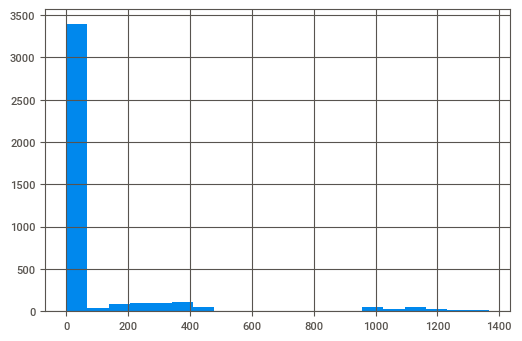

In [140]:
df['call_duration'].hist(bins=20)

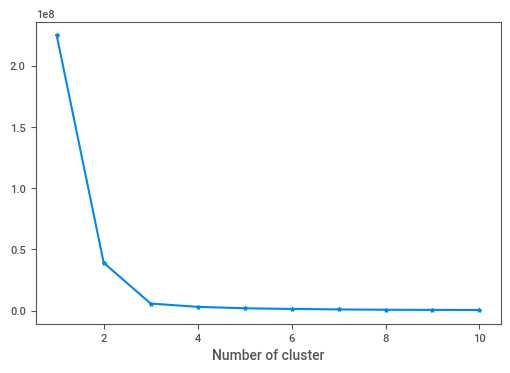

In [141]:
sse = {}
df_cluster = df[['call_duration']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), marker='*')
plt.xlabel("Number of cluster")
plt.show()

In [142]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['call_duration']])
df['call_duration_cluster'] = kmeans.predict(df[['call_duration']])

In [143]:
df = order_cluster('call_duration_cluster', 'call_duration', df, True)

In [144]:
df.drop('call_duration', axis=1, inplace=True)

In [147]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4037 entries, 0 to 4036
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   balance_amt            4037 non-null   float64
 1   household_insurance    4037 non-null   int64  
 2   car_loan               4037 non-null   int64  
 3   last_contact_day       4037 non-null   int64  
 4   last_contact_month     4037 non-null   int64  
 5   car_insurance          3102 non-null   float64
 6   age_cluster            4037 non-null   int64  
 7   blue-collar            4037 non-null   uint8  
 8   entrepreneur           4037 non-null   uint8  
 9   housemaid              4037 non-null   uint8  
 10  management             4037 non-null   uint8  
 11  retired                4037 non-null   uint8  
 12  self-employed          4037 non-null   uint8  
 13  services               4037 non-null   uint8  
 14  student                4037 non-null   uint8  
 15  tech

,balance_amt,household_insurance,car_loan,last_contact_day,last_contact_month,car_insurance,age_cluster,blue-collar,entrepreneur,housemaid,...,secondary,tertiary,telephone,contacts_cluster,days_passed_cluster,prev_attempts_cluster,other,success,unknown,call_duration_cluster
0,0.442486,1,0,13,8,0.0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-1.589477,0,1,15,8,1.0,1,0,0,0,...,0,1,0,1,1,1,1,0,0,1
2,-0.273878,1,0,16,8,1.0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0.038881,0,1,29,4,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,-0.222452,1,0,14,8,1.0,0,0,0,0,...,1,0,0,1,2,2,0,0,0,0


In [152]:
mask = df['car_insurance'].isna() == True

train = df.loc[~mask]
train['car_insurance'] = train['car_insurance'].astype(int)

test = df.loc[mask].drop('car_insurance', axis=1)

In [153]:
train.to_csv('../data/clean_train.csv', index=False)
test.to_csv('../data/clean_test.csv', index=False)